# Description 

This notebook will perform sectorized (range of angle pre-defined) radial profile over a set of files selected using same settings for all images. To get a better description of the algorithm, check the library documentation [in the github repository](https://github.com/JeanBilheux/SectorizedRadialProfile)

# Imports 

In [3]:
import custom_style
custom_style.style()

In [4]:
IPTS = "16212"

from sectorizedradialprofile.calculate_radial_profile import CalculateRadialProfile
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import matplotlib.patches as patches
%matplotlib notebook

import numpy as np
import os

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import display, HTML

import file_handler
import gui_widgets

In [5]:
%gui qt

# Import images

Select your images (tiff or fits) to work on.

In [8]:
default_dir = '/HFIR/CG1DImaging/IPTS-{}'.format(IPTS)
list_data_files = gui_widgets.gui_fimage(dir = default_dir)

if list_data_files:
    working_data = []
    for _file in list_data_files:
        _data = np.array(file_handler.load_data(_file)) 
        working_data.append(_data)

    [nbr_files, height, width] = np.shape(working_data)

# select parameters

Select **center of circle** and **sector** to use for profile

<IPython.core.display.Javascript object>


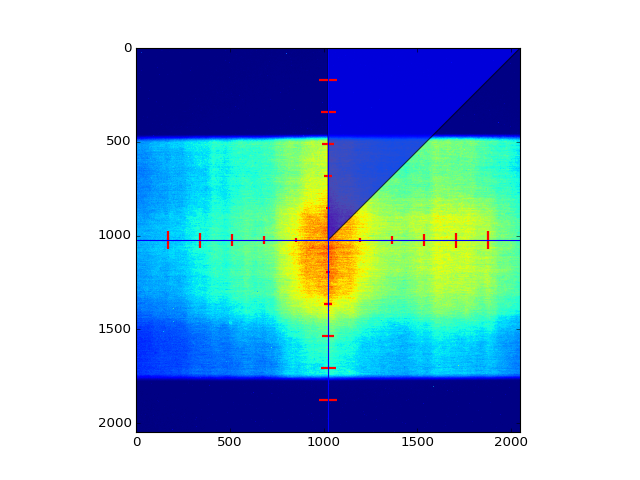

{'angle_range': {'from': 0, 'to': 45}, 'center': {'x0': 1024, 'y0': 1024}}

In [9]:
def select_center(file_index, x0, y0, from_angle, to_angle):
    
    fig, ax = plt.subplots()
    ax.imshow(working_data[file_index])
    
    min_mark_size = 10 #pixels
    
    #show center
    plt.axvline(x=x0)
    plt.axhline(y=y0)
    
    #show symetrical mark on (x0,y0) reference lines to help figure out the right center
    nbr_x_ref_lines = 5
    nbr_y_ref_lines = 5
    
    # calculate the min distance between center and edges
    working_width = np.min([x0, width-x0])
    working_height = np.min([y0, height-y0])
    
    if working_width <= 4 * nbr_x_ref_lines:
        nbr_x_ref_lines = 1
    elif working_height <= 4 * nbr_y_ref_lines:
        nbr_y_ref_lines = 1
    
    #determine the reference lines coordinates
    x_interval = working_width / (nbr_x_ref_lines + 1)
    y_interval = working_height / (nbr_y_ref_lines + 1)
    
    references_lines = []

    #right of x0
    for i in np.arange(nbr_x_ref_lines):
        mark_size = (i+1) * min_mark_size
        point1 = (x0 + (i+1) * x_interval, y0 - mark_size)
        point2 = (x0 + (i+1) * x_interval, y0 + mark_size)
        references_lines.append([point1, point2])
    
    #left of x0
    for i in np.arange(nbr_x_ref_lines):
        mark_size = (i+1) * min_mark_size
        point1 = (x0 - (i+1) * x_interval, y0 - mark_size)
        point2 = (x0 - (i+1) * x_interval, y0 + mark_size)
        references_lines.append([point1, point2])
    
    #top of y0
    for j in np.arange(nbr_y_ref_lines):
        mark_size = (j+1) * min_mark_size
        point1 = (x0 - mark_size, y0 - (j+1) * y_interval)
        point2 = (x0 + mark_size, y0 - (j+1) * y_interval)
        references_lines.append([point1, point2])

    #bottom of y0
    for j in np.arange(nbr_y_ref_lines):
        mark_size = (j+1) * min_mark_size
        point1 = (x0 - mark_size, y0 + (j+1) * y_interval)
        point2 = (x0 + mark_size, y0 + (j+1) * y_interval)
        references_lines.append([point1, point2])

    #calculate list of colors
    basic_color = (1,0,0,1)
    list_color = [basic_color for x in np.arange(len(references_lines))]
    
    lc = mc.LineCollection(references_lines, colors=list_color, linewidths=2)
    ax.add_collection(lc)
    
    #display the radius selected
    ax.add_patch(patches.Wedge((x0, y0), 
                              width,
                              from_angle-90,
                              to_angle-90,
                              alpha=0.7))
    
    center = {'x0': x0,
             'y0': y0}

    angle_range = {'from': from_angle,
                  'to': to_angle}
    
    return {'center': center, 'angle_range': angle_range}
    
preview = interact(select_center,
                    file_index = widgets.IntSlider(min=0,
                                                  max = nbr_files-1,
                                                  value=0,
                                                  description='File Index'),
                  x0 = widgets.IntSlider(min=0,
                                        max=width-1,
                                        value=np.int(width/2),
                                        description = 'x0'),
                  y0 = widgets.IntSlider(min=0,
                                        max=height-1,
                                        value=np.int(height/2),
                                        descrption= 'y0'),
                  from_angle = widgets.IntSlider(min=0,
                                               max=359,
                                               value=0,
                                               descrption='From angle'),
                  to_angle = widgets.IntSlider(min=0,
                                              max=359,
                                              value=45,
                                              descrption='to angle'))

# Calculate profiles

In [11]:
result = preview.widget.result
center = result['center']
angle_range = result['angle_range']

w = widgets.IntProgress()
w.max = nbr_files-1
display(w)

array_profile = []

for _index in np.arange(nbr_files):
    o_profile = CalculateRadialProfile(
        data=working_data[_index], center=center, angle_range=angle_range)
    o_profile.calculate()
    
    profile = o_profile.radial_profile
    array_profile.append(profile)
    
    w.value = _index+1

# Check results

<IPython.core.display.Javascript object>


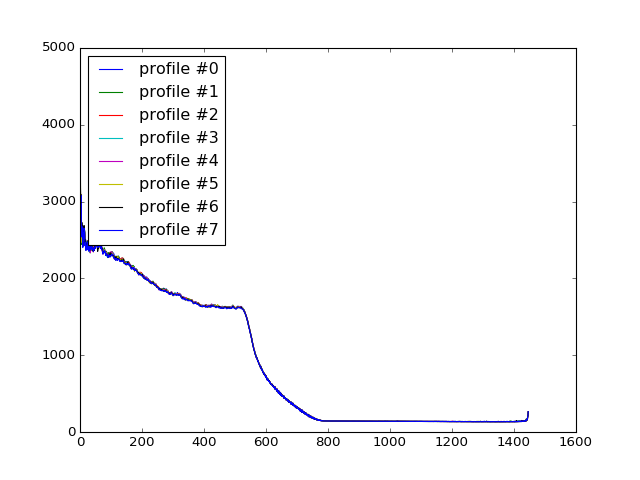

In [12]:
plt.figure(2)
for _index, _profile in enumerate(array_profile):
    plt.plot(_profile, label='profile #{}'.format(_index))
    plt.legend(loc=2)

# Output Result 

Select output folder

In [13]:
output_folder = os.path.dirname(list_data_files[0])
output_folder_name = gui_widgets.gui_dname(dir=output_folder)

for _index, _file in enumerate(list_data_files):

    [input_image_base_name, ext] = os.path.splitext(os.path.basename(_file))
    output_file_name = os.path.join(output_folder_name, input_image_base_name + '_profile_c_x{}_y{}_angle_{}_to_{}.txt'.format(center['x0'], center['y0'],
                                                                                                                         angle_range['from'], angle_range['to']))

    text = []
    text.append("# source image: {}".format(_file))
    text.append("# center [x0, y0]: [{},{}]".format(center['x0'], center['y0']))
    text.append("# angular range from {}degrees to {}degrees".format(angle_range['from'], angle_range['to']))
    text.append('')
    text.append('#pixel_from_center, Average_counts')
    data = list(zip(np.arange(len(array_profile[_index])), array_profile[_index]))

    file_handler.make_ascii_file(metadata=text, data=data, output_file_name=output_file_name)

    display(HTML('<span style="font-size: 20px; color:blue">File created: ' + output_file_name + '</span>'))